In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install tonic --quiet
!pip install torch --quiet
!pip install torchvision --quiet

In [3]:
!pip install norse --quiet

In [4]:
import tonic
import torchvision

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)

trainset = tonic.datasets.NMNIST(save_to="./data", train=True)
testset = tonic.datasets.NMNIST(
    save_to="./data", transform=frame_transform, train=False
)



In [5]:
events = trainset[0][0]
events

array([(10, 30,    937, 1), (33, 20,   1030, 1), (12, 27,   1052, 1), ...,
       ( 7, 15, 302706, 1), (26, 11, 303852, 1), (11, 17, 305341, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

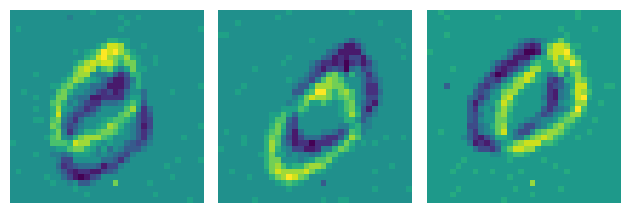

In [6]:
tonic.utils.plot_event_grid(events)

In [7]:
trainset[0][1]

0

In [8]:
# reduce this number if you run out of GPU memory
BATCH_SIZE = 512

# add sparse transform to trainset, previously omitted because we wanted to look at raw events
trainset.transform = frame_transform

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=False,
)

In [9]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self,
        input_features,
        hidden_features,
        output_features,
        tau_syn_inv,
        tau_mem_inv,
        record=False,
        dt=1e-3,
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(
                alpha=100,
                v_th=torch.as_tensor(0.3),
                tau_syn_inv=tau_syn_inv,
                tau_mem_inv=tau_mem_inv,
            ),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        # Stellen Sie sicher, dass die Eingabe und alle Zustände auf dem gleichen Gerät sind
        device = next(self.parameters()).device  # Gerät des Modells
        x = x.to(device)  # Eingabe auf das richtige Gerät verschieben
        seq_length, batch_size, _, _, _ = x.shape

        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features, device=device),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features, device=device),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features, device=device),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features, device=device),
                    i=torch.zeros(seq_length, batch_size, self.output_features, device=device),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)  # LIF-Schicht
            z = self.fc_out(z)  # Vollverbundene Schicht
            vo, so = self.out(z, so)  # LI-Schicht
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)


In [10]:
example_snn = SNN(
    np.product(trainset.sensor_size),
    100,
    len(trainset.classes),
    tau_syn_inv=torch.tensor(1 / 1e-2),
    tau_mem_inv=torch.tensor(1 / 1e-2),
    record=True,
    dt=1e-3,
)

frames, target = next(iter(train_loader))

frames[:, :1].shape

torch.Size([313, 1, 2, 34, 34])

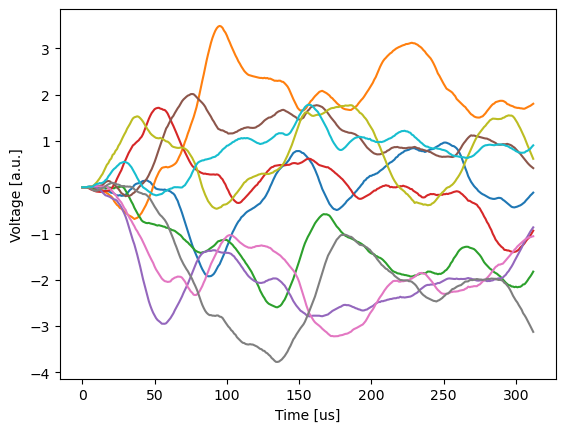

In [11]:
example_readout_voltages = example_snn(frames[:, :1])
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [us]")
plt.show()

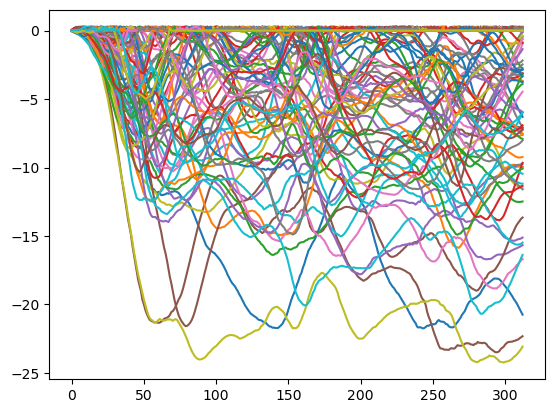

In [12]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

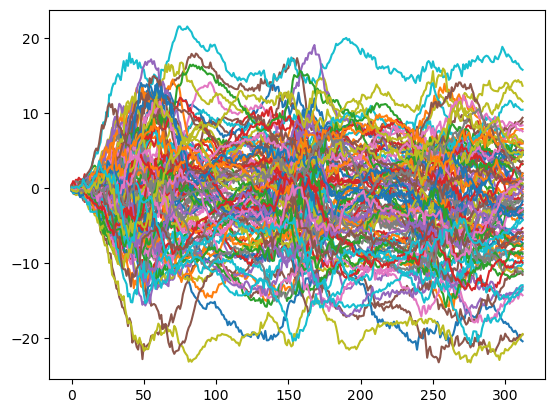

In [13]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

Final accuracy: 95.78%

Anmerkung: Ausführungszeit = 4 Stunden

In [14]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import tonic


In [15]:
# Decoder-Funktion
def decode(x):
    return torch.nn.functional.log_softmax(torch.max(x, 0)[0], dim=1)


In [16]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y


class Model(torch.nn.Module):
    def __init__(self, snn, decoder):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [17]:
LR = 0.002
INPUT_FEATURES = np.product(trainset.sensor_size)
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = len(trainset.classes)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
        tau_syn_inv=torch.tensor(1 / 1e-2),
        tau_mem_inv=torch.tensor(1 / 1e-2),
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=2312, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(100.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.3000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [18]:
# Optimierer initialisieren
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [19]:
from tqdm.notebook import tqdm, trange
import torch
import numpy as np

EPOCHS = 60  # Number of epochs
PATIENCE = 5  # Early stopping patience (number of epochs with no improvement)
BEST_TEST_LOSS = float('inf')  # Best test loss initialized to infinity
PATIENT_EPOCHS = 0  # Counter for epochs without improvement

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    correct_train = 0
    total_train = 0

    for data, target in tqdm(train_loader, leave=False, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        data, target = data.to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # Calculate training accuracy
        pred = output.argmax(dim=1)
        correct_train += pred.eq(target).sum().item()
        total_train += target.size(0)

    mean_loss = np.mean(losses)
    train_accuracy = 100.0 * correct_train / total_train
    return mean_loss, train_accuracy


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=False, desc=f"Testing Epoch {epoch+1}/{EPOCHS}"):
            data, target = data.to(device), target.long().to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    return test_loss, accuracy


# Main training and testing loop with early stopping
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in trange(EPOCHS, desc="Epoch Progress"):
    # Training
    train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Testing
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Print the results for each epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {train_loss:.4f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.4f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )

    # Early stopping logic
    if test_loss < BEST_TEST_LOSS:
        BEST_TEST_LOSS = test_loss  # Update best test loss
        PATIENT_EPOCHS = 0  # Reset patience counter
    else:
        PATIENT_EPOCHS += 1  # Increment patience counter
    
    if PATIENT_EPOCHS >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break


Epoch Progress:   0%|          | 0/60 [00:00<?, ?it/s]

Training Epoch 1/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 1/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 2.1286, Train Accuracy: 28.27%, Test Loss: 2.0671, Test Accuracy: 30.71%


Training Epoch 2/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 2/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 1.5907, Train Accuracy: 50.48%, Test Loss: 1.1046, Test Accuracy: 70.16%


Training Epoch 3/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 3/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.8546, Train Accuracy: 75.33%, Test Loss: 0.6235, Test Accuracy: 81.88%


Training Epoch 4/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 4/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.5591, Train Accuracy: 83.38%, Test Loss: 0.4570, Test Accuracy: 86.37%


Training Epoch 5/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 5/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.4540, Train Accuracy: 86.33%, Test Loss: 0.3951, Test Accuracy: 88.06%


Training Epoch 6/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 6/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.4899, Train Accuracy: 85.28%, Test Loss: 0.4152, Test Accuracy: 87.48%


Training Epoch 7/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 7/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.3708, Train Accuracy: 88.81%, Test Loss: 0.3358, Test Accuracy: 89.67%


Training Epoch 8/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 8/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.3465, Train Accuracy: 89.38%, Test Loss: 0.3124, Test Accuracy: 90.37%


Training Epoch 9/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 9/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.3286, Train Accuracy: 90.11%, Test Loss: 0.2852, Test Accuracy: 91.18%


Training Epoch 10/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 10/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.3280, Train Accuracy: 90.27%, Test Loss: 0.3005, Test Accuracy: 90.58%


Training Epoch 11/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 11/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.5197, Train Accuracy: 84.53%, Test Loss: 0.3331, Test Accuracy: 90.36%


Training Epoch 12/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 12/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.3205, Train Accuracy: 90.56%, Test Loss: 0.2850, Test Accuracy: 91.43%


Training Epoch 13/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 13/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.3423, Train Accuracy: 89.67%, Test Loss: 0.4367, Test Accuracy: 87.20%


Training Epoch 14/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 14/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.3190, Train Accuracy: 90.42%, Test Loss: 0.2541, Test Accuracy: 92.27%


Training Epoch 15/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 15/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.2858, Train Accuracy: 91.44%, Test Loss: 0.3225, Test Accuracy: 90.69%


Training Epoch 16/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 16/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.3024, Train Accuracy: 90.85%, Test Loss: 0.2700, Test Accuracy: 91.98%


Training Epoch 17/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 17/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.2811, Train Accuracy: 91.45%, Test Loss: 0.3464, Test Accuracy: 89.55%


Training Epoch 18/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 18/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.2782, Train Accuracy: 91.73%, Test Loss: 0.2247, Test Accuracy: 93.20%


Training Epoch 19/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 19/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.2200, Train Accuracy: 93.46%, Test Loss: 0.2173, Test Accuracy: 93.49%


Training Epoch 20/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 20/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.3589, Train Accuracy: 89.11%, Test Loss: 0.2422, Test Accuracy: 92.67%


Training Epoch 21/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 21/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.2297, Train Accuracy: 93.15%, Test Loss: 0.2206, Test Accuracy: 93.30%


Training Epoch 22/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 22/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.2036, Train Accuracy: 93.95%, Test Loss: 0.1944, Test Accuracy: 94.21%


Training Epoch 23/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 23/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.1844, Train Accuracy: 94.52%, Test Loss: 0.1940, Test Accuracy: 94.06%


Training Epoch 24/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 24/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.2072, Train Accuracy: 93.77%, Test Loss: 0.2589, Test Accuracy: 92.07%


Training Epoch 25/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 25/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.2139, Train Accuracy: 93.56%, Test Loss: 0.1888, Test Accuracy: 94.31%


Training Epoch 26/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 26/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.2037, Train Accuracy: 93.87%, Test Loss: 0.2144, Test Accuracy: 93.36%


Training Epoch 27/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 27/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.2132, Train Accuracy: 93.55%, Test Loss: 0.2221, Test Accuracy: 93.25%


Training Epoch 28/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 28/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.2579, Train Accuracy: 92.31%, Test Loss: 0.2159, Test Accuracy: 93.31%


Training Epoch 29/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 29/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.2367, Train Accuracy: 92.62%, Test Loss: 0.2101, Test Accuracy: 93.77%


Training Epoch 30/60:   0%|          | 0/118 [00:00<?, ?it/s]

Testing Epoch 30/60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.2774, Train Accuracy: 91.56%, Test Loss: 0.2467, Test Accuracy: 92.46%
Early stopping triggered at epoch 30.


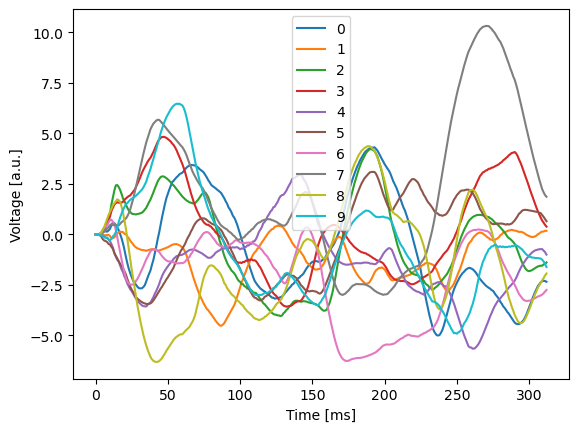

In [20]:
# Start 19:48 --> 60 Epochen --> Ende 06:20 = 8 Stunden 30 Minuten

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_snn = model.snn.to(DEVICE)
frames = frames.to(DEVICE)

# Hier gehen wir davon aus, dass 'frames' mehrere Eingabebeispiele enthalten kann.
trained_readout_voltages = trained_snn(frames[:, :1])  # Nur das erste Beispiel (falls frames mehr als eines enthält)

# Um die Spannung zu plotten, holen wir die Daten von der GPU und konvertieren sie zu NumPy
voltages = trained_readout_voltages.squeeze(1).cpu().detach().numpy()

# Falls mehrere Klassen oder Kanäle vorhanden sind, iteriere durch sie
for i in range(voltages.shape[1]):  # Annahme: Zweite Dimension entspricht den Klassen/Kanälen
    plt.plot(voltages[:, i], label=f"{i}")

# Achsenbeschriftung
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")

# Legende anzeigen
plt.legend()

# Plot anzeigen
plt.show()


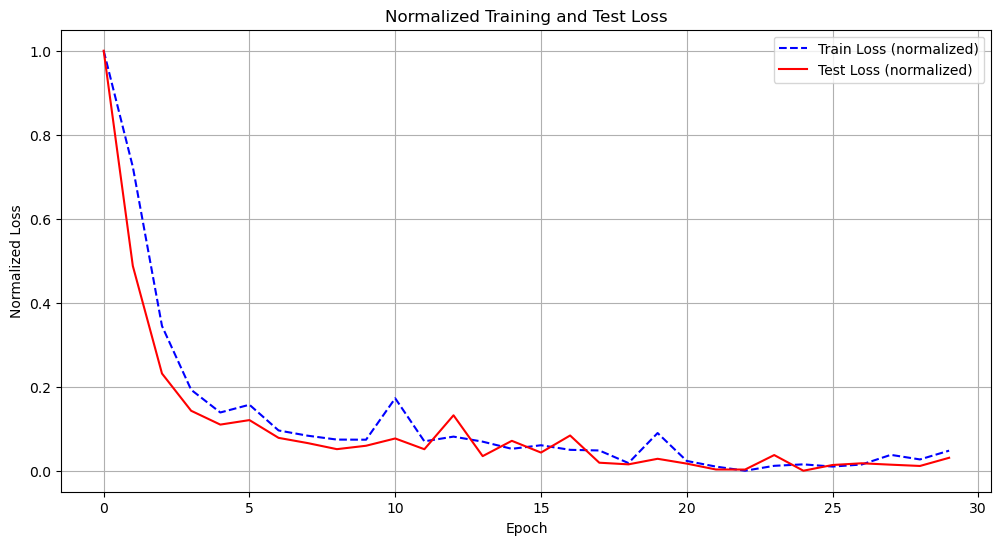

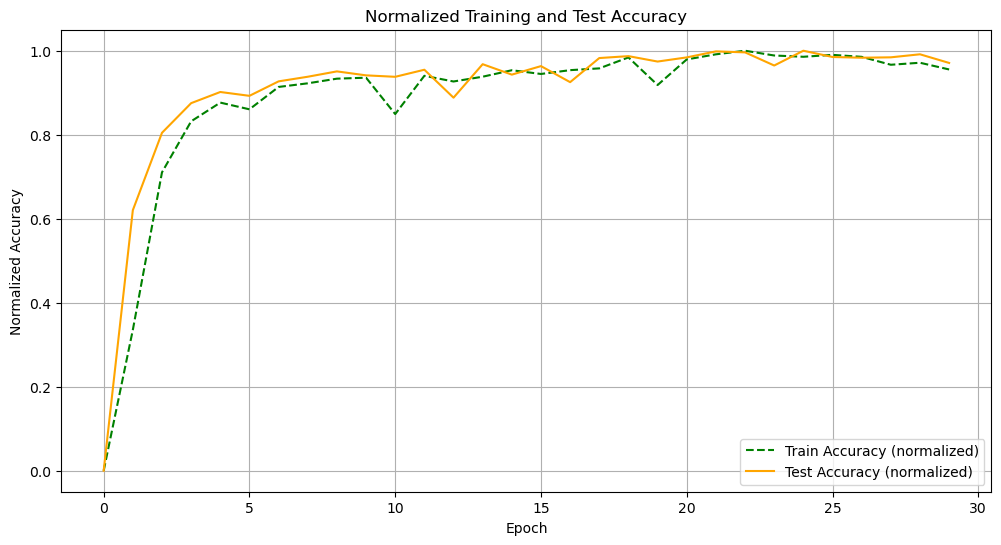

In [25]:
import matplotlib.pyplot as plt

# Normalisiere eine Liste auf den Bereich [0, 1]
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val) if max_val > min_val else data

# Normalisierte Verluste und Genauigkeiten berechnen
train_losses_norm = normalize(train_losses)
test_losses_norm = normalize(test_losses)
train_accuracies_norm = normalize(train_accuracies)
test_accuracies_norm = normalize(test_accuracies)

# Plotten der Verluste
plt.figure(figsize=(12, 6))
plt.plot(train_losses_norm, label="Train Loss (normalized)", color="blue", linestyle="--")
plt.plot(test_losses_norm, label="Test Loss (normalized)", color="red")
plt.title("Normalized Training and Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plotten der Genauigkeiten
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies_norm, label="Train Accuracy (normalized)", color="green", linestyle="--")
plt.plot(test_accuracies_norm, label="Test Accuracy (normalized)", color="orange")
plt.title("Normalized Training and Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Normalized Accuracy")
plt.legend()
plt.grid(True)
plt.show()
